In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import lightgbm as lgb
from lightgbm import LGBMClassifier

import torch
import torch.nn as nn

from sklearn.metrics import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the dataset

df = pd.read_csv('Data/diabetes2.csv')

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1


# Preparing the Data

In [4]:
# split the df into train and test set
X = df.drop(columns='Outcome')
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [5]:
y_train.value_counts()  # imbalanced class counts

0    401
1    213
Name: Outcome, dtype: int64

In [6]:
y_train.value_counts()/213

0    1.882629
1    1.000000
Name: Outcome, dtype: float64

That is an imbalance of almost 2 between the non-diabetics and diabetics patients.

In [7]:
# upsampling the minority class to address class imbalance
from imblearn.over_sampling import SMOTE

upsampler = SMOTE(random_state=42)

X_train_os, y_train_os = upsampler.fit_resample(X_train, y_train)

In [8]:
y_train_os.value_counts()   # the counts of the two classes is balanced now!

0    401
1    401
Name: Outcome, dtype: int64

In [9]:
# scaling the data

scaler = StandardScaler()

X_train_scaled_os = scaler.fit_transform(X_train_os)
X_test_scaled_os = scaler.transform(X_test)

### I'll also define some functions that will be used during model training and evaluation

In [10]:
# since this is a problem of imbalance class classification, MCC is the best metric for evaluation of model performance
# I will make my own scorer function for MCC to use in grid search cv
def matthews_correlation(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    mcc = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    
    return mcc

mcc = make_scorer(matthews_correlation, greater_is_better=True)

In [11]:
# function to create performance metrics dataframe at all thresholds from 0-1
# the reason why i am including this is since we are dealing with a problem where we 
# will most likely be wanting a model that predicts more number of false positives as compared false negatives
# so that we're more likely to tell a person who's healthy that they're not healthy and have them
# spend a little more money on tests to be relieved when they reveal that they're not suffering
# as compared to telling a non-healthy person that they are healthy and increase their risk of not surviving by not 
# getting treated on time
# having a look at the performance of our model at all the prediction thresholds will help us 
# decide on the lowest threshold we can go while maintaining a good performance!

def metrics_df(model, X_train, X_test, y_train, y_test):
    threshold_list = np.arange(0,1.05,0.05)
    metrics = []
    for i in threshold_list:
        y_preds_tr = (model.predict_proba(X_train)[:,1] > i).astype("float")
        y_preds_ts = (model.predict_proba(X_test)[:,1] > i).astype("float")
        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_preds_tr).ravel()
        tn_ts, fp_ts, fn_ts, tp_ts = confusion_matrix(y_test, y_preds_ts).ravel()
        sens_tr = recall_score(y_train, y_preds_tr)
        sens_ts = recall_score(y_test, y_preds_ts)
        spec_tr = tn_tr / (tn_tr + fp_tr)
        spec_ts = tn_ts / (tn_ts + fp_ts)
        acc_tr = accuracy_score(y_train, y_preds_tr)
        acc_ts = accuracy_score(y_test, y_preds_ts)
        prec_tr = precision_score(y_train, y_preds_tr)
        prec_ts = precision_score(y_test, y_preds_ts)
        npv_tr = tn_tr / (tn_tr + fn_tr)
        npv_ts = tn_ts / (tn_ts + fn_ts)
        mcc_tr = matthews_corrcoef(y_train, y_preds_tr)
        mcc_ts = matthews_corrcoef(y_test, y_preds_ts)
        metrics.append([sens_tr,sens_ts,spec_tr,spec_ts,acc_tr,acc_ts,prec_tr,prec_ts,npv_tr,npv_ts,mcc_tr,mcc_ts])
    model_metrics = pd.DataFrame(metrics, index=threshold_list, columns= ['Sens/Recall_train','Sens/Recall_test', 
                                                                       'Spec_train', 'Spec_test', 
                                                                       'Accuracy_train','Accuracy_test',
                                                                       'precision/PPV_train', 'precision/PPV_test',
                                                                       'npv_train','npv_test',
                                                                       'mcc_train','mcc_test'])
    model_metrics.index.name = 'Threshold'
    return model_metrics

# Training the Models

## 1. KNN

In [15]:
n_neighbours = range(1,11)

train_score = []
test_score = []

for n in n_neighbours:
    
    knn = KNeighborsClassifier(n_neighbors = n)
    
    knn.fit(X_train_scaled_os, y_train_os)
    
    train_score.append(matthews_corrcoef(y_train_os, knn.predict(X_train_scaled_os)))
    test_score.append(matthews_corrcoef(y_test, knn.predict(X_test_scaled_os)))

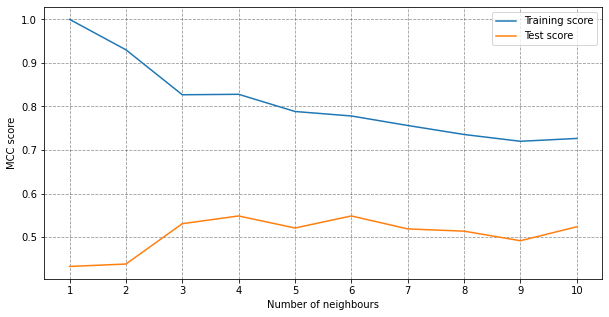

In [16]:
plt.figure(figsize=(10,5))
plt.plot(n_neighbours, train_score, label= 'Training score')
plt.plot(n_neighbours, test_score, label = 'Test score')
plt.grid(alpha=0.4, color='k', linestyle='--')
plt.xticks(ticks=n_neighbours, labels=n_neighbours)
plt.xlabel('Number of neighbours')
plt.ylabel('MCC score')
plt.legend()
plt.show()

Depending upon the above plot, working with 6 neighbours seems to be providing the best generalised result.

In [17]:
knn = KNeighborsClassifier(n_neighbors=6)

# checking cross validation performance
scores = cross_val_score(knn, X_train_scaled_os, y_train_os, cv = StratifiedKFold(), scoring = mcc)
print(f'cross validation scores: {np.mean(scores)}')

# fitting the model
knn.fit(X_train_scaled_os, y_train_os)

cross validation scores: 0.681643313765084


KNeighborsClassifier(n_neighbors=6)

In [310]:
# evaulating the model
knn_metrics = metrics_df(knn, X_train_scaled_os, X_test_scaled_os, y_train_os, y_test)
knn_metrics

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,0.963636,0.481297,0.383838,0.740648,0.590909,0.658456,0.464912,1.000000,0.950000,0.562950,0.379699
0.05,1.000000,0.963636,0.481297,0.383838,0.740648,0.590909,0.658456,0.464912,1.000000,0.950000,0.562950,0.379699
0.10,1.000000,0.963636,0.481297,0.383838,0.740648,0.590909,0.658456,0.464912,1.000000,0.950000,0.562950,0.379699
0.15,1.000000,0.963636,0.481297,0.383838,0.740648,0.590909,0.658456,0.464912,1.000000,0.950000,0.562950,0.379699
0.20,0.995012,0.927273,0.630923,0.545455,0.812968,0.681818,0.729433,0.531250,0.992157,0.931034,0.672063,0.467477
0.25,0.995012,0.927273,0.630923,0.545455,0.812968,0.681818,0.729433,0.531250,0.992157,0.931034,0.672063,0.467477
0.30,0.995012,0.927273,0.630923,0.545455,0.812968,0.681818,0.729433,0.531250,0.992157,0.931034,0.672063,0.467477
0.35,0.957606,0.854545,0.775561,0.646465,0.866584,0.720779,0.810127,0.573171,0.948171,0.888889,0.745626,0.481141
0.40,0.957606,0.854545,0.775561,0.646465,0.866584,0.720779,0.810127,0.573171,0.948171,0.888889,0.745626,0.481141


Although the average cv MCC score for the model on validation dataset was 0.68, the best MCC score recieved on test data is ~0.55 at the prediction threshold of 0.50

## 2. Logistic Regression

### 2.1. training model on oversampled ds

In [19]:
param_grid_lr = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

logreg = LogisticRegression(random_state=42)

stratified = StratifiedKFold()

grid_lr = GridSearchCV(logreg, param_grid_lr, scoring = mcc, cv = stratified, return_train_score = True)

grid_lr.fit(X_train_scaled_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [20]:
pd.DataFrame(grid_lr.cv_results_)[['params','mean_train_score','mean_test_score']].\
sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
8,{'C': 1},0.578312,0.567558
7,{'C': 0.7},0.577702,0.565259
5,{'C': 0.3},0.575897,0.560684
6,{'C': 0.5},0.578952,0.560424
4,{'C': 0.1},0.572188,0.551160
3,{'C': 0.01},0.550013,0.548562
2,{'C': 0.001},0.544064,0.538335
1,{'C': 0.0001},0.535970,0.531917
0,{'C': 1e-05},0.514407,0.518615


The best generalised model seems to be the one with C:1

In [21]:
model_lr = grid_lr.best_estimator_

model_lr.fit(X_train_scaled_os, y_train_os)

LogisticRegression(C=1, random_state=42)

AUPRC for logreg is : 0.75


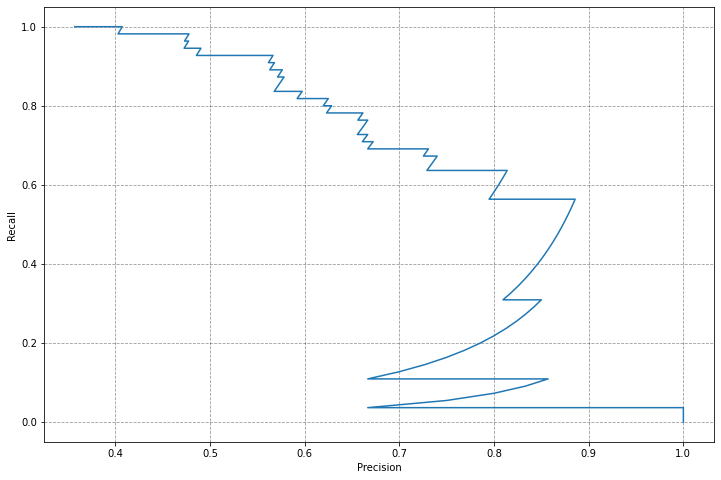

In [22]:
# AU-PRC
precision, recall, thresholds = precision_recall_curve(y_test, model_lr.decision_function(X_test_scaled_os))

plt.figure(figsize=(12,8))
plt.plot(precision, recall)
plt.grid(alpha = 0.4, color = 'k', linestyle = '--')
plt.xlabel('Precision')
plt.ylabel('Recall')

print(f'AUPRC for logreg is : {round(average_precision_score(y_test, model_lr.decision_function(X_test_scaled_os)),2)}')

In [23]:
# MCC
matthews_corrcoef(y_test, model_lr.predict(X_test_scaled_os))

0.5171145012542265

In [311]:
metrics_df(model_lr, X_train_scaled_os, X_test_scaled_os, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.104738,0.070707,0.552369,0.402597,0.527632,0.374150,1.000000,1.000000,0.235081,0.162650
0.10,0.997506,0.981818,0.244389,0.252525,0.620948,0.512987,0.568990,0.421875,0.989899,0.961538,0.367685,0.299751
0.15,0.992519,0.981818,0.381546,0.373737,0.687032,0.590909,0.616099,0.465517,0.980769,0.973684,0.472512,0.395172
0.20,0.990025,0.945455,0.476309,0.414141,0.733167,0.603896,0.654036,0.472727,0.979487,0.931818,0.543538,0.381409
0.25,0.975062,0.927273,0.538653,0.494949,0.756858,0.649351,0.678819,0.504950,0.955752,0.924528,0.570955,0.425835
0.30,0.945137,0.927273,0.600998,0.565657,0.773067,0.694805,0.703154,0.542553,0.916350,0.933333,0.581664,0.484333
0.35,0.910224,0.909091,0.640898,0.606061,0.775561,0.714286,0.717092,0.561798,0.877133,0.923077,0.572268,0.499784
0.40,0.885287,0.854545,0.708229,0.646465,0.796758,0.720779,0.752119,0.573171,0.860606,0.888889,0.603044,0.481141


The highest test MCC score achieved by LR trained on oversampled data is of 0.537484 at the prediction threshold of 0.55.

### 2.2. Training model with class weights to deal with the class imbalance

In [24]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train.to_numpy())
weights = compute_class_weight(class_weight='balanced', classes = classes, y = y_train)
class_weights = dict(zip(classes, weights))

class_weights

{0: 0.7655860349127181, 1: 1.4413145539906103}

In [25]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid_lr = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

logreg = LogisticRegression(class_weight=class_weights, random_state=42)

stratified = StratifiedKFold()

grid_lr2 = GridSearchCV(logreg, param_grid_lr, scoring = mcc, cv = stratified, return_train_score = True)

grid_lr2.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight={0: 0.7655860349127181,
                                                        1: 1.4413145539906103},
                                          random_state=42),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [26]:
pd.DataFrame(grid_lr2.cv_results_)[['params','mean_train_score','mean_test_score']].\
sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
8,{'C': 1},0.561922,0.532898
6,{'C': 0.5},0.560887,0.528531
7,{'C': 0.7},0.562288,0.528531
5,{'C': 0.3},0.563334,0.525739
4,{'C': 0.1},0.559515,0.524277
3,{'C': 0.01},0.539309,0.520253
2,{'C': 0.001},0.527672,0.518634
1,{'C': 0.0001},0.527243,0.507249
0,{'C': 1e-05},0.360216,0.416172


In [27]:
model_lr2 = grid_lr2.best_estimator_

model_lr2.fit(X_train_scaled, y_train)

LogisticRegression(C=1,
                   class_weight={0: 0.7655860349127181, 1: 1.4413145539906103},
                   random_state=42)

In [28]:
matthews_corrcoef(y_test, model_lr2.predict(X_test_scaled))

0.5171145012542265

In [29]:
metrics_df(model_lr2, X_train_scaled, X_test_scaled, y_train, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.346906,0.357143,0.346906,0.357143,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.089776,0.070707,0.405537,0.402597,0.368512,0.374150,1.000000,1.000000,0.181888,0.162650
0.10,0.995305,0.981818,0.231920,0.252525,0.496743,0.512987,0.407692,0.421875,0.989362,0.961538,0.300368,0.299751
0.15,0.990610,0.981818,0.376559,0.373737,0.589577,0.590909,0.457701,0.465517,0.986928,0.973684,0.404047,0.395172
0.20,0.985915,0.945455,0.483791,0.424242,0.657980,0.610390,0.503597,0.477064,0.984772,0.933333,0.478946,0.389516
0.25,0.976526,0.927273,0.538653,0.474747,0.690554,0.636364,0.529262,0.495146,0.977376,0.921569,0.510891,0.409301
0.30,0.938967,0.927273,0.596010,0.565657,0.714984,0.694805,0.552486,0.542553,0.948413,0.933333,0.517658,0.484333
0.35,0.906103,0.909091,0.638404,0.606061,0.731270,0.714286,0.571006,0.561798,0.927536,0.923077,0.521018,0.499784
0.40,0.887324,0.854545,0.710723,0.636364,0.771987,0.714286,0.619672,0.566265,0.922330,0.887324,0.569335,0.471880


The highest test MCC is 0.517115 at the prediction threshold of 0.50 . The other high scoring test MCC performances are not well generalised.

## 3. Naive Bayes

In [30]:
# training the model
# Naive bayes models have almost no hyperparameters to tune and usually generalise well
# and since it is doesnot make predictions based on distance, it is not sensitive to the scale of the feature!

nb = GaussianNB()

scores = cross_val_score(nb, X_train_os, y_train_os, cv = StratifiedKFold(), scoring=mcc)
print(f'The cross validation scores for NB is: {np.mean(scores)}')

The cross validation scores for NB is: 0.5196442424103842


In [31]:
# fitting the model
nb.fit(X_train_os, y_train_os)

# testing the performance
print(f"Confusion matrix for NB:\n {confusion_matrix(y_test, nb.predict(X_test))}")
print(f"MCC score for NB: {matthews_corrcoef(y_test, nb.predict(X_test))}")

Confusion matrix for NB:
 [[76 23]
 [14 41]]
MCC score for NB: 0.4989031178371752


In [32]:
nb_metrics = metrics_df(nb, X_train_os, X_test, y_train_os, y_test)
nb_metrics

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.05,0.982544,0.981818,0.389027,0.333333,0.685786,0.564935,0.616588,0.450000,0.957055,0.970588,0.461681,0.364073
0.10,0.967581,0.945455,0.491272,0.414141,0.729426,0.603896,0.655405,0.472727,0.938095,0.931818,0.521852,0.381409
0.15,0.935162,0.927273,0.553616,0.505051,0.744389,0.655844,0.676895,0.510000,0.895161,0.925926,0.528780,0.434121
0.20,0.910224,0.909091,0.605985,0.585859,0.758105,0.701299,0.697897,0.549451,0.870968,0.920635,0.541898,0.482357
0.25,0.887781,0.909091,0.650873,0.636364,0.769327,0.733766,0.717742,0.581395,0.852941,0.926471,0.554437,0.526325
0.30,0.860349,0.872727,0.683292,0.666667,0.771820,0.740260,0.730932,0.592593,0.830303,0.904110,0.552368,0.517608
0.35,0.830424,0.836364,0.725686,0.666667,0.778055,0.727273,0.751693,0.582278,0.810585,0.880000,0.559185,0.482224
0.40,0.790524,0.800000,0.760599,0.696970,0.775561,0.733766,0.767554,0.594595,0.784062,0.862500,0.551369,0.476615


**The best generalised performance on the test set is of MCC = 0.500257 at the prediction threshold of 0.45. The other scores of MCC = 0.551727 and 0.593377 on the test set at prediction threshold of 0.80 and 0.85 show incredibly underfit performance due to a lower train set MCC score.**

## 4. Support Vector Machine

### 4.1. training model on oversampled ds

In [33]:
# the most commonly used method of scaling for kernel svm is min max scaling
mm_scaler = MinMaxScaler()

X_train_mmscaled = mm_scaler.fit_transform(X_train_os)
X_test_mmscaled = mm_scaler.transform(X_test)

In [34]:
param_gridSVC = {'C': [1, 10, 100],
                 'gamma':[0.01, 0.1, 1, 10, 100]}

svc1 = SVC(probability=True, random_state=42)

gridsvm1 = GridSearchCV(svc1, param_gridSVC, cv = stratified, n_jobs=-1, scoring=mcc, return_train_score=True)

gridsvm1.fit(X_train_mmscaled, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [35]:
pd.DataFrame(gridsvm1.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
12,"{'C': 100, 'gamma': 1}",0.812117,0.716761
9,"{'C': 10, 'gamma': 100}",1.000000,0.703030
14,"{'C': 100, 'gamma': 100}",1.000000,0.703030
4,"{'C': 1, 'gamma': 100}",0.998133,0.701964
13,"{'C': 100, 'gamma': 10}",1.000000,0.697525
7,"{'C': 10, 'gamma': 1}",0.741013,0.690405
8,"{'C': 10, 'gamma': 10}",0.961361,0.687872
3,"{'C': 1, 'gamma': 10}",0.830499,0.668471
11,"{'C': 100, 'gamma': 0.1}",0.690169,0.657163
2,"{'C': 1, 'gamma': 1}",0.677720,0.645815


In [36]:
model_svc1 = gridsvm1.best_estimator_
model_svc1.fit(X_train_mmscaled, y_train_os)

SVC(C=100, gamma=1, probability=True, random_state=42)

In [37]:
matthews_corrcoef(y_test, model_svc1.predict(X_test_mmscaled))

0.6039839682815216

In [38]:
# let's check the train set and test set performance of the model on all the thresholds
metrics_df(model_svc1, X_train_mmscaled, X_test_mmscaled, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.05,0.997506,0.963636,0.251870,0.222222,0.624688,0.487013,0.571429,0.407692,0.990196,0.916667,0.374241,0.245530
0.10,0.997506,0.909091,0.413965,0.404040,0.705736,0.584416,0.629921,0.458716,0.994012,0.888889,0.506686,0.329918
0.15,0.995012,0.890909,0.506234,0.535354,0.750623,0.662338,0.668342,0.515789,0.990244,0.898305,0.574555,0.420135
0.20,0.987531,0.872727,0.600998,0.616162,0.794264,0.707792,0.712230,0.558140,0.979675,0.897059,0.638127,0.471743
0.25,0.977556,0.872727,0.763092,0.646465,0.870324,0.727273,0.804928,0.578313,0.971429,0.901408,0.758292,0.499067
0.30,0.965087,0.854545,0.810474,0.717172,0.887781,0.766234,0.835853,0.626667,0.958702,0.898734,0.785001,0.548070
0.35,0.960100,0.836364,0.832918,0.737374,0.896509,0.772727,0.851770,0.638889,0.954286,0.890244,0.799510,0.550984
0.40,0.937656,0.836364,0.855362,0.787879,0.896509,0.805195,0.866359,0.686567,0.932065,0.896552,0.795716,0.603330


So, the best test set performance of MCC = 0.645095 by SVC is at the prediction threshold of 0.55

### 4.2. Training model with class weights to deal with the class imbalance

In [39]:
param_gridSVC = {'C': [1, 10, 100],
                 'gamma':[0.01, 0.1, 1, 10, 100]}

svc2 = SVC(class_weight=class_weights, probability=True)

gridsvm2 = GridSearchCV(svc2, param_gridSVC, cv = stratified, n_jobs=-1, scoring=mcc, return_train_score=True)

gridsvm2.fit(X_train_mmscaled, y_train_os)

/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_5643/2475837710.py:6: RuntimeWarning: invalid value encountered in true_divide


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(class_weight={0: 0.7655860349127181,
                                         1: 1.4413145539906103},
                           probability=True),
             n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [40]:
pd.DataFrame(gridsvm2.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
3,"{'C': 1, 'gamma': 10}",0.799407,0.710569
9,"{'C': 10, 'gamma': 100}",1.000000,0.703030
14,"{'C': 100, 'gamma': 100}",1.000000,0.703030
12,"{'C': 100, 'gamma': 1}",0.803991,0.702855
7,"{'C': 10, 'gamma': 1}",0.734083,0.701570
13,"{'C': 100, 'gamma': 10}",0.998755,0.695262
8,"{'C': 10, 'gamma': 10}",0.953434,0.692888
11,"{'C': 100, 'gamma': 0.1}",0.673620,0.649791
2,"{'C': 1, 'gamma': 1}",0.633595,0.608968
10,"{'C': 100, 'gamma': 0.01}",0.608958,0.606495


In [41]:
model_svc2 = gridsvm2.best_estimator_
model_svc2.fit(X_train_mmscaled, y_train_os)

SVC(C=1, class_weight={0: 0.7655860349127181, 1: 1.4413145539906103}, gamma=10,
    probability=True)

In [42]:
matthews_corrcoef(y_test, model_svc2.predict(X_test_mmscaled))

0.5906761086703622

In [43]:
# let's check the train set and test set performance of the model on all the thresholds
metrics_df(model_svc2, X_train_mmscaled, X_test_mmscaled, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.05,0.995012,0.963636,0.528678,0.383838,0.761845,0.590909,0.678571,0.464912,0.990654,0.950000,0.592003,0.379699
0.10,0.992519,0.927273,0.658354,0.525253,0.825436,0.668831,0.743925,0.520408,0.988764,0.928571,0.690570,0.450749
0.15,0.982544,0.927273,0.715711,0.616162,0.849127,0.727273,0.775591,0.573034,0.976190,0.938462,0.724524,0.527223
0.20,0.982544,0.909091,0.770574,0.626263,0.876559,0.727273,0.810700,0.574713,0.977848,0.925373,0.770629,0.517419
0.25,0.977556,0.909091,0.793017,0.646465,0.885287,0.740260,0.825263,0.588235,0.972477,0.927536,0.784039,0.535294
0.30,0.972569,0.909091,0.812968,0.696970,0.892768,0.772727,0.838710,0.625000,0.967359,0.932432,0.795736,0.581238
0.35,0.970075,0.890909,0.825436,0.727273,0.897756,0.785714,0.847495,0.644737,0.965015,0.923077,0.803965,0.592463
0.40,0.965087,0.854545,0.842893,0.737374,0.903990,0.779221,0.860000,0.643836,0.960227,0.901235,0.814081,0.568012


So, the best test set performance of MCC = 0.570342 by SVC(class weights) is at the prediction threshold of 0.50.
And if we compare it with the model trained on oversampled dataset, that gives better results than working with class weights.

**Clearly, the linear models haven't had a very good performance on this dataset, which is understandable since we didn't see any variable pair having a linear relationship. In addition we also did not remove the outliers which  affects the training and further performance on test dataset.**

## 5. Decision Tree

Tree based models should work better for our dataset, since as seen by the pair plot and the correlation matrix, there is no linear relationship and strong correlation respectively amongst the variables, and tree based models are known to work well even when the variables have a non-linear or no relationship amongst them. In addition they are also robust to outliers such that their performance will not be affected by their presence.

### 5.1. training model on oversampled ds

In [44]:
decTree1 = DecisionTreeClassifier(random_state=40)

param_grid_dt = {'max_depth':[2,3,4,5,7,8,9],
                 'min_samples_leaf':[1,2,3,4,5]}

grid_dt1 = GridSearchCV(decTree1, param_grid_dt, scoring=mcc, cv=stratified, return_train_score=True)

grid_dt1.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=40),
             param_grid={'max_depth': [2, 3, 4, 5, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [45]:
pd.DataFrame(grid_dt1.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
30,"{'max_depth': 9, 'min_samples_leaf': 1}",0.993150,0.811358
31,"{'max_depth': 9, 'min_samples_leaf': 2}",0.951292,0.808864
25,"{'max_depth': 8, 'min_samples_leaf': 1}",0.981968,0.806870
20,"{'max_depth': 7, 'min_samples_leaf': 1}",0.963300,0.804503
26,"{'max_depth': 8, 'min_samples_leaf': 2}",0.946930,0.803842
21,"{'max_depth': 7, 'min_samples_leaf': 2}",0.934395,0.797887
16,"{'max_depth': 5, 'min_samples_leaf': 2}",0.878571,0.781824
32,"{'max_depth': 9, 'min_samples_leaf': 3}",0.933990,0.778352
15,"{'max_depth': 5, 'min_samples_leaf': 1}",0.881761,0.776852
29,"{'max_depth': 8, 'min_samples_leaf': 5}",0.893032,0.776681


The model with max_depth:5 and min_samples_leaf:2 seems to be the model with best generalised performance.

In [46]:
model_dt1 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 2)

model_dt1.fit(X_train_os, y_train_os)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2)

In [47]:
matthews_corrcoef(y_test, model_dt1.predict(X_test))

0.7400071661639241

As expected!! Decision tree achieves a much higher MCC score on the test dataset as compared to any of the earlier models including the linear models. We do see quite a bit of overfitting in the cross validation results which is expected with DTs since they overfit easily, but if this model is still able to give a good MCC score on the test set, it means that despite overfitting to the training dataset it did learn information to perform well enough on the test dataset.

In [48]:
# let's check the train set and test set performance of the model on all the thresholds
metrics_df(model_dt1, X_train_os, X_test, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,0.981818,0.541147,0.515152,0.770574,0.681818,0.685470,0.529412,1.000000,0.980769,0.609049,0.503532
0.05,1.000000,0.981818,0.541147,0.515152,0.770574,0.681818,0.685470,0.529412,1.000000,0.980769,0.609049,0.503532
0.10,0.982544,0.945455,0.827930,0.777778,0.905237,0.837662,0.850972,0.702703,0.979351,0.962500,0.820338,0.693611
0.15,0.975062,0.927273,0.880299,0.797980,0.927681,0.844156,0.890661,0.718310,0.972452,0.951807,0.859228,0.697140
0.20,0.975062,0.927273,0.880299,0.797980,0.927681,0.844156,0.890661,0.718310,0.972452,0.951807,0.859228,0.697140
0.25,0.967581,0.927273,0.902743,0.838384,0.935162,0.870130,0.908665,0.761194,0.965333,0.954023,0.872159,0.740007
0.30,0.967581,0.927273,0.902743,0.838384,0.935162,0.870130,0.908665,0.761194,0.965333,0.954023,0.872159,0.740007
0.35,0.967581,0.927273,0.902743,0.838384,0.935162,0.870130,0.908665,0.761194,0.965333,0.954023,0.872159,0.740007
0.40,0.967581,0.927273,0.902743,0.838384,0.935162,0.870130,0.908665,0.761194,0.965333,0.954023,0.872159,0.740007


### 5.2. Training model with class weights to deal with the class imbalance

In [49]:
decTree2 = DecisionTreeClassifier(random_state=42, class_weight=class_weights)

param_grid_dt = {'max_depth':[2,3,4,5,7,8,9],
                 'min_samples_leaf':[1,2,3,4,5]}

grid_dt2 = GridSearchCV(decTree2, param_grid_dt, scoring=mcc, cv=stratified, return_train_score=True)

grid_dt2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(class_weight={0: 0.7655860349127181,
                                                            1: 1.4413145539906103},
                                              random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [50]:
pd.DataFrame(grid_dt2.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
15,"{'max_depth': 5, 'min_samples_leaf': 1}",0.865175,0.674581
17,"{'max_depth': 5, 'min_samples_leaf': 3}",0.847730,0.660966
18,"{'max_depth': 5, 'min_samples_leaf': 4}",0.831830,0.658411
30,"{'max_depth': 9, 'min_samples_leaf': 1}",0.993726,0.656764
12,"{'max_depth': 4, 'min_samples_leaf': 3}",0.784738,0.656208
16,"{'max_depth': 5, 'min_samples_leaf': 2}",0.859185,0.655076
27,"{'max_depth': 8, 'min_samples_leaf': 3}",0.906991,0.651257
28,"{'max_depth': 8, 'min_samples_leaf': 4}",0.880668,0.648713
8,"{'max_depth': 3, 'min_samples_leaf': 4}",0.756001,0.647359
9,"{'max_depth': 3, 'min_samples_leaf': 5}",0.753678,0.645726


In [59]:
# upon testing different parameter combinations from above df
# model with max_depth=5 and min_samples_leaf=3 has the best performance on test dataset 
# together with being quite generalised thus I will be going with this parameter combination
model_dt2 = DecisionTreeClassifier(class_weight = class_weights, max_depth = 5, min_samples_leaf = 3)

model_dt2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.7655860349127181,
                                     1: 1.4413145539906103},
                       max_depth=5, min_samples_leaf=3)

In [60]:
matthews_corrcoef(y_test, model_dt2.predict(X_test))

0.7188918942063234

In [62]:
# let's check the train set and test set performance of the model on all the thresholds
metrics_df(model_dt2, X_train_os, X_test, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,0.992519,1.000000,0.473815,0.464646,0.733167,0.655844,0.653530,0.509259,0.984456,1.000000,0.545449,0.486442
0.05,0.985037,0.981818,0.605985,0.585859,0.795511,0.727273,0.714286,0.568421,0.975904,0.983051,0.638684,0.559516
0.10,0.977556,0.981818,0.755611,0.686869,0.866584,0.792208,0.800000,0.635294,0.971154,0.985507,0.751921,0.644299
0.15,0.977556,0.981818,0.755611,0.686869,0.866584,0.792208,0.800000,0.635294,0.971154,0.985507,0.751921,0.644299
0.20,0.962594,0.981818,0.802993,0.696970,0.882793,0.798701,0.830108,0.642857,0.955490,0.985714,0.775527,0.653197
0.25,0.945137,0.927273,0.867830,0.757576,0.906484,0.818182,0.877315,0.680000,0.940541,0.949367,0.815408,0.656522
0.30,0.942643,0.890909,0.880299,0.767677,0.911471,0.811688,0.887324,0.680556,0.938830,0.926829,0.824547,0.632467
0.35,0.935162,0.890909,0.900249,0.808081,0.917706,0.837662,0.903614,0.720588,0.932817,0.930233,0.835921,0.674475
0.40,0.927681,0.890909,0.907731,0.808081,0.917706,0.837662,0.909535,0.720588,0.926209,0.930233,0.835578,0.674475


decision tree with class weights performs a bit worse as compared to DT built on oversampled dataset, nonetheless, its best performance on the test set seems to be at the prediction thresholds of 0.70-0.75 of 0.722791 which is quite a high threshold that we wouldn't want to work with. Best would be the default prediction threshold of 0.5 which yield a test set MCC score of 0.718892, quite close to the best one!

**Overall we can see that there is still quite a bit of difference in the train set and test set performance which indicates that DT overfits on the training dataset, which is a bit expected since DT does tend to overfit, but this problem should be resolved using RandomForestClassifiers which is more robust to overfitting!**

## 6. Random Forest Classifier

### 6.1. training model on oversampled ds

In [63]:
rfc1 = RandomForestClassifier(random_state=42)

param_grid_rfc = {'n_estimators': [100, 200, 300, 400, 500, 600, 1000],
                 'max_depth': [3,5,7],
                 'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]}

gridrfc1 = GridSearchCV(rfc1, param_grid_rfc, n_jobs = -1, cv = stratified, scoring=mcc, return_train_score = True)

gridrfc1.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 1000]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [64]:
pd.options.display.max_rows = 200    # increasing the number of rows to display

In [65]:
rfc_results = pd.DataFrame(gridrfc1.cv_results_)[['params','mean_train_score','mean_test_score']]

In [66]:
# we need to find the best generalised model
rfc_results['train_test_diff'] = rfc_results['mean_train_score']-rfc_results['mean_test_score']
rfc_results.sort_values(by='train_test_diff')

,params,mean_train_score,mean_test_score,train_test_diff
5,"{'max_depth': 3, 'max_features': 0.5, 'n_estim...",0.787259,0.752409,0.034850
12,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",0.787259,0.752409,0.034850
11,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",0.785509,0.750170,0.035340
4,"{'max_depth': 3, 'max_features': 0.5, 'n_estim...",0.785509,0.750170,0.035340
3,"{'max_depth': 3, 'max_features': 0.5, 'n_estim...",0.786677,0.749917,0.036760
10,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",0.786677,0.749917,0.036760
15,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.787514,0.749171,0.038343
17,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.785795,0.747032,0.038764
16,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.786323,0.747032,0.039291
6,"{'max_depth': 3, 'max_features': 0.5, 'n_estim...",0.787340,0.747944,0.039395


In [67]:
# saving the parameters of the model providing the most generalised results
# let's go with index 5 since it seems to be the most generalised model
gen_params = rfc_results.iloc[5,0]
gen_params

{'max_depth': 3, 'max_features': 0.5, 'n_estimators': 600}

In [68]:
model_rfc1 = RandomForestClassifier(max_depth=gen_params['max_depth'], max_features=gen_params['max_features'],
                                    n_estimators = gen_params['n_estimators'])
model_rfc1.fit(X_train_os, y_train_os)

RandomForestClassifier(max_depth=3, max_features=0.5, n_estimators=600)

In [69]:
# performance of the generalised model on test dataset
matthews_corrcoef(y_test, model_rfc1.predict(X_test))

0.7126718091024599

In [70]:
# let's check the train set and test set performance of the model on all the thresholds
metrics_df(model_rfc1, X_train_os, X_test, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.154613,0.171717,0.577307,0.467532,0.541892,0.401460,1.000000,1.000000,0.289454,0.262560
0.10,0.997506,0.981818,0.508728,0.505051,0.753117,0.675325,0.670017,0.524272,0.995122,0.980392,0.580272,0.495686
0.15,0.992519,0.963636,0.643392,0.656566,0.817955,0.766234,0.735675,0.609195,0.988506,0.970149,0.678612,0.599425
0.20,0.980050,0.963636,0.725686,0.707071,0.852868,0.798701,0.781312,0.646341,0.973244,0.972222,0.729738,0.644108
0.25,0.977556,0.963636,0.758105,0.747475,0.867830,0.824675,0.801636,0.679487,0.971246,0.973684,0.754042,0.681526
0.30,0.975062,0.945455,0.788030,0.787879,0.881546,0.844156,0.821429,0.712329,0.969325,0.962963,0.776800,0.703714
0.35,0.952618,0.945455,0.802993,0.808081,0.877805,0.857143,0.828633,0.732394,0.944282,0.963855,0.764214,0.724326
0.40,0.945137,0.945455,0.822943,0.818182,0.884040,0.863636,0.842222,0.742857,0.937500,0.964286,0.773879,0.734847


At the threshold of 0.40 we see the highest test set MCC score of MCC = 0.734847. And as compared to the DT,as expected the performance of RFC is quite a generalised performance when we compare the train set, val set and the test set scores!!

In [71]:
# we can also compare this with the best model according to the gridsearchCV
best_model_rfc1 = gridrfc1.best_estimator_
best_model_rfc1.fit(X_train_os, y_train_os)

RandomForestClassifier(max_depth=7, max_features=0.8, n_estimators=200,
                       random_state=42)

In [72]:
matthews_corrcoef(y_test, best_model_rfc1.predict(X_test))

0.730426770358672

The performance of this best model looks good, even better than the generalised model, but let's take a look at all the metrics scores.

In [73]:
metrics_df(best_model_rfc1, X_train_os, X_test, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.05,1.000000,0.981818,0.680798,0.585859,0.840399,0.727273,0.758034,0.568421,1.000000,0.983051,0.718379,0.559516
0.10,1.000000,0.963636,0.775561,0.656566,0.887781,0.766234,0.816701,0.609195,1.000000,0.970149,0.795865,0.599425
0.15,1.000000,0.963636,0.827930,0.707071,0.913965,0.798701,0.853191,0.646341,1.000000,0.972222,0.840466,0.644108
0.20,1.000000,0.963636,0.870324,0.727273,0.935162,0.811688,0.885210,0.662500,1.000000,0.972973,0.877735,0.662612
0.25,1.000000,0.945455,0.907731,0.757576,0.953865,0.824675,0.915525,0.684211,1.000000,0.961538,0.911620,0.673781
0.30,1.000000,0.927273,0.930175,0.818182,0.965087,0.857143,0.934732,0.739130,1.000000,0.952941,0.932450,0.718267
0.35,1.000000,0.927273,0.935162,0.838384,0.967581,0.870130,0.939110,0.761194,1.000000,0.954023,0.937134,0.740007
0.40,1.000000,0.909091,0.952618,0.838384,0.976309,0.863636,0.954762,0.757576,1.000000,0.943182,0.953690,0.723739


With almost the same test score wrt all metrics, the training score for this model is in the 90s or even a 100 for many metrics, and hence this model is quite complex and overfit as compared to the model we are calling (and rightly so) the generalised model.

### 6.2. Training model with class weights to deal with the class imbalance

In [74]:
rfc2 = RandomForestClassifier(class_weight=class_weights, random_state=42)

gridrfc2 = GridSearchCV(rfc2, param_grid_rfc, n_jobs = -1, cv = stratified, scoring=mcc, return_train_score = True)

gridrfc2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight={0: 0.7655860349127181,
                                                            1: 1.4413145539906103},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 1000]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [75]:
rfc_results2 = pd.DataFrame(gridrfc2.cv_results_)[['params','mean_train_score','mean_test_score']]

In [76]:
# we need to find the best generalised model
rfc_results2['train_test_diff'] = rfc_results2['mean_train_score']-rfc_results2['mean_test_score']
rfc_results2.sort_values(by='train_test_diff')

,params,mean_train_score,mean_test_score,train_test_diff
18,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.759301,0.704178,0.055122
17,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.757865,0.701567,0.056298
0,"{'max_depth': 3, 'max_features': 0.5, 'n_estim...",0.768939,0.712561,0.056378
7,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",0.768939,0.712561,0.056378
14,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.759329,0.701028,0.058301
20,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.761484,0.702775,0.058708
19,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.759010,0.700164,0.058846
15,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.756885,0.697014,0.059871
16,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.758308,0.697554,0.060754
1,"{'max_depth': 3, 'max_features': 0.5, 'n_estim...",0.763917,0.702521,0.061396


In [77]:
# saving the parameters of the model providing the most generalised results
# let's go with index 0, since the combination of train and val set performance seems to be the best
gen_params = rfc_results.iloc[0,0]
gen_params

{'max_depth': 3, 'max_features': 0.5, 'n_estimators': 100}

In [78]:
model_rfc2 = RandomForestClassifier(max_depth=gen_params['max_depth'], max_features=gen_params['max_features'],
                                    n_estimators = gen_params['n_estimators'])
model_rfc2.fit(X_train_os, y_train_os)

RandomForestClassifier(max_depth=3, max_features=0.5)

In [79]:
matthews_corrcoef(y_test, model_rfc2.predict(X_test))

0.7400071661639241

In [80]:
# let's check the train set and test set performance of the model on all the thresholds
metrics_df(model_rfc2, X_train, X_test, y_train, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.346906,0.357143,0.346906,0.357143,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.162095,0.191919,0.452769,0.480519,0.387978,0.407407,1.000000,1.000000,0.250777,0.279623
0.10,0.995305,0.981818,0.513716,0.545455,0.680782,0.701299,0.520885,0.545455,0.995169,0.981818,0.512525,0.527273
0.15,0.990610,0.981818,0.663342,0.656566,0.776873,0.772727,0.609827,0.613636,0.992537,0.984848,0.627628,0.618112
0.20,0.976526,0.963636,0.733167,0.717172,0.817590,0.805195,0.660317,0.654321,0.983278,0.972603,0.675836,0.653311
0.25,0.971831,0.945455,0.768080,0.737374,0.838762,0.811688,0.690000,0.666667,0.980892,0.960526,0.704557,0.654420
0.30,0.953052,0.945455,0.795511,0.777778,0.850163,0.837662,0.712281,0.702703,0.969605,0.962500,0.714447,0.693611
0.35,0.943662,0.945455,0.805486,0.797980,0.853420,0.850649,0.720430,0.722222,0.964179,0.963415,0.716152,0.713951
0.40,0.943662,0.945455,0.817955,0.818182,0.861564,0.863636,0.733577,0.742857,0.964706,0.964286,0.729263,0.734847


**We can again see that the performance of the model is quite generalised!**

## 7. Gradient Boosted Machine

In [81]:
gbm = GradientBoostingClassifier(random_state=42)

param_gridGBM = {'n_estimators': [100, 150, 200, 250, 300],
                 'learning_rate':[0.01, 0.05, 0.1, 0.3],
                 'max_depth': [2,3,4,5,6,7,8,9]}

gridGBM = GridSearchCV(gbm, param_gridGBM, scoring=mcc, n_jobs=-1, cv=stratified, return_train_score=True)

gridGBM.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [100, 150, 200, 250, 300]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [82]:
gbm_results = pd.DataFrame(gridGBM.cv_results_)[['params','mean_train_score','mean_test_score']]

In [83]:
# we need to find the best generalised model
gbm_results['train_test_diff'] = gbm_results['mean_train_score']-gbm_results['mean_test_score']
gbm_results.sort_values(by='train_test_diff')

,params,mean_train_score,mean_test_score,train_test_diff
0,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.762412,0.729026,0.033386
1,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.776199,0.732006,0.044193
4,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.822639,0.770688,0.051951
3,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.809126,0.753567,0.055559
2,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.797834,0.741439,0.056395
5,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.829852,0.760970,0.068882
40,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.860583,0.782911,0.077672
41,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.882426,0.802813,0.079613
6,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.846449,0.760770,0.085679
7,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.857678,0.767935,0.089743


In [84]:
# let's go with index 4 as the difference between train and test is of 0.05
# and at the same time the performance is also good

gen_param = gbm_results.iloc[4,0] # extract the parameters
gen_model_gbm = GradientBoostingClassifier(learning_rate=gen_param['learning_rate'], max_depth=gen_param['max_depth'],
                                       n_estimators=gen_param['n_estimators'], random_state=42)

gen_model_gbm.fit(X_train_os, y_train_os)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=300,
                           random_state=42)

In [85]:
matthews_corrcoef(y_test, gen_model_gbm.predict(X_test))

0.7463904912524668

In [87]:
# let's also store the best model
best_model_gbm = gridGBM.best_estimator_
best_model_gbm.fit(X_train_os, y_train_os)

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, n_estimators=250,
                           random_state=42)

In [88]:
matthews_corrcoef(y_test, best_model_gbm.predict(X_test))

0.643236547597133

**The generalised model has a much better performance!!**

In [89]:
metrics_df(gen_model_gbm, X_train_os, X_test, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.10,0.997506,0.981818,0.406484,0.434343,0.701995,0.629870,0.626959,0.490909,0.993902,0.977273,0.500821,0.441406
0.15,0.995012,0.981818,0.578554,0.656566,0.786783,0.772727,0.702465,0.613636,0.991453,0.984848,0.630879,0.618112
0.20,0.982544,0.945455,0.738155,0.707071,0.860349,0.792208,0.789579,0.641975,0.976898,0.958904,0.743235,0.626170
0.25,0.970075,0.945455,0.778055,0.767677,0.874065,0.831169,0.813808,0.693333,0.962963,0.962025,0.762316,0.683635
0.30,0.962594,0.927273,0.800499,0.797980,0.881546,0.844156,0.828326,0.718310,0.955357,0.951807,0.773319,0.697140
0.35,0.962594,0.909091,0.832918,0.818182,0.897756,0.850649,0.852097,0.735294,0.957020,0.941860,0.802285,0.701766
0.40,0.950125,0.909091,0.855362,0.818182,0.902743,0.850649,0.867882,0.735294,0.944904,0.941860,0.809127,0.701766


**For GBM we see the best generalised MCC performance of 0.75 at the prediction threshold of 0.55. As compared to RFC the performance is better but RFC gives more generalised results.**

In [90]:
metrics_df(best_model_gbm, X_train_os, X_test, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.0,1.000000,0.0,0.000000,0.5,0.357143,0.5,0.357143,NaN,NaN,0.0,0.000000
0.05,1.0,0.836364,1.0,0.828283,1.0,0.831169,1.0,0.730159,1.0,0.901099,1.0,0.647737
0.10,1.0,0.818182,1.0,0.828283,1.0,0.824675,1.0,0.725806,1.0,0.891304,1.0,0.631617
0.15,1.0,0.818182,1.0,0.838384,1.0,0.831169,1.0,0.737705,1.0,0.892473,1.0,0.643237
0.20,1.0,0.818182,1.0,0.838384,1.0,0.831169,1.0,0.737705,1.0,0.892473,1.0,0.643237
0.25,1.0,0.818182,1.0,0.838384,1.0,0.831169,1.0,0.737705,1.0,0.892473,1.0,0.643237
0.30,1.0,0.818182,1.0,0.838384,1.0,0.831169,1.0,0.737705,1.0,0.892473,1.0,0.643237
0.35,1.0,0.818182,1.0,0.838384,1.0,0.831169,1.0,0.737705,1.0,0.892473,1.0,0.643237
0.40,1.0,0.818182,1.0,0.838384,1.0,0.831169,1.0,0.737705,1.0,0.892473,1.0,0.643237


As expected, the best model gives a worse performance on the test set with the perfect train score for all metrics at all thresholds. Highly overfit to the training dataset.

## 8. LGBMClassifier

In [91]:
lgb = LGBMClassifier(objective='binary', random_state=42)

param_grid_lgb = {'n_estimators':[100,200,300],
              'learning_rate': [0.01, 0.05, 0.1, 0.3],
              'num_leaves':[20,31,50,80,100]}

gridlgb = GridSearchCV(lgb, param_grid_lgb, scoring=mcc, n_jobs=-1, cv=stratified, return_train_score=True)

gridlgb.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(objective='binary', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 31, 50, 80, 100]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [92]:
lgb_results = pd.DataFrame(gridlgb.cv_results_)[['params','mean_train_score','mean_test_score']]

# we need to find the best generalised model
lgb_results['train_test_diff'] = lgb_results['mean_train_score']-lgb_results['mean_test_score']
lgb_results.sort_values(by='train_test_diff')

,params,mean_train_score,mean_test_score,train_test_diff
1,"{'learning_rate': 0.01, 'n_estimators': 100, '...",0.853445,0.786265,0.067180
2,"{'learning_rate': 0.01, 'n_estimators': 100, '...",0.853445,0.786265,0.067180
3,"{'learning_rate': 0.01, 'n_estimators': 100, '...",0.853445,0.786265,0.067180
4,"{'learning_rate': 0.01, 'n_estimators': 100, '...",0.853445,0.786265,0.067180
0,"{'learning_rate': 0.01, 'n_estimators': 100, '...",0.852816,0.783597,0.069220
6,"{'learning_rate': 0.01, 'n_estimators': 200, '...",0.915260,0.812107,0.103153
7,"{'learning_rate': 0.01, 'n_estimators': 200, '...",0.915260,0.812107,0.103153
8,"{'learning_rate': 0.01, 'n_estimators': 200, '...",0.915260,0.812107,0.103153
9,"{'learning_rate': 0.01, 'n_estimators': 200, '...",0.915260,0.812107,0.103153
5,"{'learning_rate': 0.01, 'n_estimators': 200, '...",0.915260,0.807072,0.108187


In [93]:
# selecting the very first index as the most generalised model
# even in this we can see quite a lot of difference between the train and val set performance
# this is because lgb is such powerful model that it tends to overfit regardless
gen_params = lgb_results.iloc[1,0]
gen_params

{'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 31}

In [94]:
gen_model_lgb = LGBMClassifier(learning_rate=gen_params['learning_rate'], n_estimators=gen_params['n_estimators'],
                               num_leaves=gen_params['num_leaves'], random_state=42)
gen_model_lgb.fit(X_train_os, y_train_os)

LGBMClassifier(learning_rate=0.01, random_state=42)

In [95]:
matthews_corrcoef(y_test, gen_model_lgb.predict(X_test))

0.6828300631878077

In [96]:
metrics_df(gen_model_lgb, X_train_os, X_test, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.10,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.15,1.000000,1.000000,0.000000,0.000000,0.500000,0.357143,0.500000,0.357143,NaN,NaN,0.000000,0.000000
0.20,1.000000,0.963636,0.443890,0.515152,0.721945,0.675325,0.642628,0.524752,1.000000,0.962264,0.534094,0.482885
0.25,0.997506,0.963636,0.693267,0.707071,0.845387,0.798701,0.764818,0.646341,0.996416,0.972222,0.725148,0.644108
0.30,0.995012,0.927273,0.760599,0.787879,0.877805,0.837662,0.806061,0.708333,0.993485,0.951220,0.777268,0.686790
0.35,0.995012,0.890909,0.837905,0.818182,0.916459,0.844156,0.859914,0.731343,0.994083,0.931034,0.843391,0.685336
0.40,0.987531,0.890909,0.852868,0.818182,0.920200,0.844156,0.870330,0.731343,0.985591,0.931034,0.848124,0.685336


**We see the best test MCC score of 0.713048 at the prediction threshold of 0.65, and when we look at the train MCC, the model seems to be overfitting slightly, but for such a powerful model that performance seems generalised enough as it has been applied to a simple & small dataset.**

In [97]:
# let us also fit the best estimator wrt the best val set MCC performance of 0.87
best_model_lgb = gridlgb.best_estimator_
best_model_lgb.fit(X_train_os, y_train_os)

LGBMClassifier(n_estimators=300, objective='binary', random_state=42)

In [99]:
matthews_corrcoef(y_test, best_model_lgb.predict(X_test)) # the performance is only slightly better

0.6916550356719819

In [100]:
metrics_df(best_model_lgb, X_train_os, X_test, y_train_os, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.0,1.000000,0.0,0.000000,0.5,0.357143,0.5,0.357143,NaN,NaN,0.0,0.000000
0.05,1.0,0.909091,1.0,0.838384,1.0,0.863636,1.0,0.757576,1.0,0.943182,1.0,0.723739
0.10,1.0,0.890909,1.0,0.848485,1.0,0.863636,1.0,0.765625,1.0,0.933333,1.0,0.718892
0.15,1.0,0.836364,1.0,0.848485,1.0,0.844156,1.0,0.754098,1.0,0.903226,1.0,0.670945
0.20,1.0,0.818182,1.0,0.848485,1.0,0.837662,1.0,0.750000,1.0,0.893617,1.0,0.655040
0.25,1.0,0.818182,1.0,0.848485,1.0,0.837662,1.0,0.750000,1.0,0.893617,1.0,0.655040
0.30,1.0,0.818182,1.0,0.858586,1.0,0.844156,1.0,0.762712,1.0,0.894737,1.0,0.667038
0.35,1.0,0.818182,1.0,0.868687,1.0,0.850649,1.0,0.775862,1.0,0.895833,1.0,0.679240
0.40,1.0,0.818182,1.0,0.878788,1.0,0.857143,1.0,0.789474,1.0,0.896907,1.0,0.691655


**The train set performance wrt almost all the metrices at almost all the thresholds is a 100%, however, the test set performance is much lower with the highest test MCC score being 0.723739 at a ridiculous threshold of 0.05, other than this a decent performance of MCC 0.679240 is seen at the prediction threshold of 0.35 which is much lower than the corresponding train set signifying overfitting and also much less than the performance of the generalised model.**

# Comparing Model Performance
## At the end, let's compare the ROC curves for each model

In [101]:
def AUC_plotter(model_dict):
    # make the figure
    plt.figure(figsize=(12,8))
    
    for k,v in model_dict.items():
        if k == 'KNN' or k == 'SVC' or k == 'LR':
            
            # printing the AU-ROC
            print(f"AU-ROC score for {k} is: \
            {roc_auc_score(y_test, v.predict_proba(X_test_scaled)[:,1])}")
            
            # plot the ROC for that model
            fpr, tpr, threshold = roc_curve(y_test, v.predict_proba(X_test_scaled)[:,1])
            plt.plot(fpr,tpr,label=k)
            
        else:
            # printing the AU-ROC
            print(f"AU-ROC score for {k} is: \
            {roc_auc_score(y_test, v.predict_proba(X_test)[:,1])}")
            
            # plot the ROC for that model
            fpr, tpr, threshold = roc_curve(y_test, v.predict_proba(X_test)[:,1])
            plt.plot(fpr,tpr,label=k)
            
    plt.xlabel('FPR', fontsize=17)
    plt.ylabel('TPR', fontsize=17)
    plt.title('Comparative plot of ROC for each model', fontsize=17)
    plt.legend()
    plt.grid()
    plt.show()

In [102]:
model_dict = {'KNN'   :knn, 
              'LR'    :model_lr, 
              'SVC'   :model_svc1, 
              'NB'    :nb,
              'DT'    :model_dt1,
              'RFC'   :model_rfc2,
              'GBM'   :gen_model_gbm,
              'LGBM'  :gen_model_lgb}

AU-ROC score for KNN is:             0.8414141414141414
AU-ROC score for LR is:             0.8591368227731864
AU-ROC score for SVC is:             0.7564738292011018
AU-ROC score for NB is:             0.8451790633608816
AU-ROC score for DT is:             0.9339761248852159
AU-ROC score for RFC is:             0.9381083562901744
AU-ROC score for GBM is:             0.9434343434343434
AU-ROC score for LGBM is:             0.934435261707989


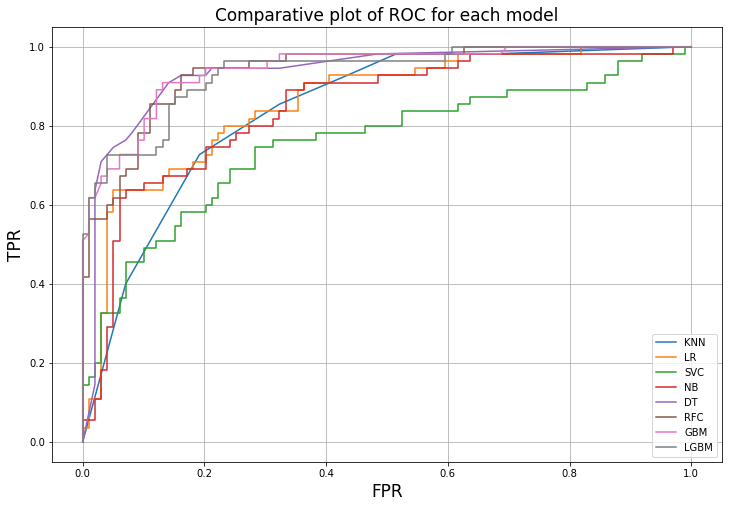

In [103]:
AUC_plotter(model_dict)

**So, GBM has the best performance whereas SVC has the worst**

# Explaining model performance: Using SHAP

In [104]:
import shap

In [246]:
# saving the feature/column names into a list
columns = [i for i in df.columns]

In [308]:
def shap_value_plots(shap_values, data, model_name, feature_names = None):
    sns.set(font_scale=1.0)
    plt.figure(figsize=(15,6))
    
    if feature_names:
        plt.subplot(1,2,1)
        shap.summary_plot(shap_values, data, feature_names=feature_names, plot_size=None, show=False)

        plt.subplot(1,2,2)
        shap.summary_plot(shap_values, data, plot_type='bar',feature_names=feature_names, plot_size=None, show=False)
        
        plt.suptitle(f'Summary plots for \n{model_name}', x=0,y=1, fontsize=20)
        
    else:
        plt.subplot(1,2,1)
        shap.summary_plot(shap_values, data, plot_size=None, show=False)

        plt.subplot(1,2,2)
        shap.summary_plot(shap_values, data, plot_type='bar', plot_size=None, show=False)
        
        plt.suptitle(f'Summary plots for \n{model_name}', x=0,y=1, fontsize=15)

### 1. KNN

In [127]:
# insert your model into explainer object
explainer_knn = shap.KernelExplainer(knn.predict, X_test_scaled_os)

# calculate the shap values
shap_values_knn = explainer_knn.shap_values(pd.DataFrame(X_test_scaled_os, index=X_test.index, columns=X_test.columns))

Using 154 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/154 [00:00<?, ?it/s]

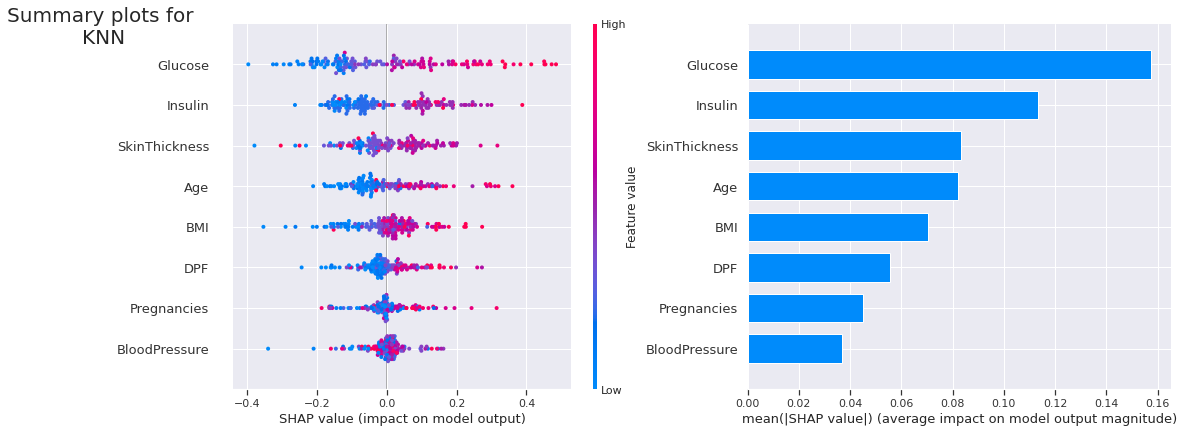

In [309]:
shap_value_plots(shap_values_knn, X_test_scaled_os, 'KNN', feature_names=columns)

We can see the variables listed in decreasing order of their impact on the disease outcome.

So, for KNN, the feature Plasma Glucose concentration has the highest impact on diabetic outcome for a patient. 
- As the Glucose value increases, the person is more likely to be diabetic.
- In decreasing order of their impact, after glucose,for all the other features the probability of being diabetic increases with increase in the variable value.
- except for diastolic blood pressure in which we can see an intermingling of red of blue indicating that there is not much relation between the value of bp and its impact on model output(disease outcome). We had also seen this while exploring the dataset that the diastolic BP values for the diabetic and non-diabetic patients are almost the same!

### 2. LogisticRegression

In [204]:
# insert trained model into explainer object
explainer_lr = shap.LinearExplainer(model_lr, X_train_scaled_os)

# calculate shap values
shap_values_lr = explainer_lr(pd.DataFrame(X_test_scaled_os, index=X_test.index, columns=X_test.columns))

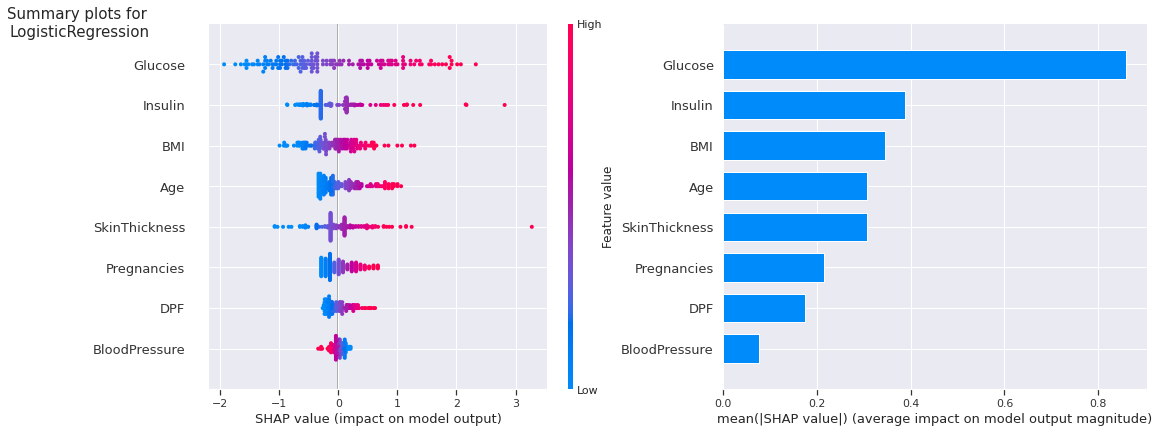

In [262]:
shap_value_plots(shap_values_lr, X_test_scaled_os, 'LogisticRegression')

We can see the variables listed in decreasing order of their impact on the disease outcome.

So, even for LR, the feature Plasma Glucose concentration has the highest impact on diabetic outcome for a patient. 
- As the Glucose value increases, the person is more likely to be diabetic.
- For LR, BMI and Age had more impacts on the model predictions as compared to skin thickness.
- Blood Pressure is still the feature with the least impact on predictions.
- In decreasing order of their impact, after glucose,for all the other features the probability of being diabetic increases with increase in the variable value.
- except for diastolic blood pressure, the increasing value of which makes the person less likely to be diabetic.

### 3. Support Vector Classifier

In [289]:
# insert trained model into explainer object
explainer_SVC = shap.KernelExplainer(model_svc1.predict_proba, X_train_mmscaled, nsamples = 100)
    
# calculate shap values
shap_values_svc = explainer_SVC.shap_values(X_test_mmscaled)

Using 802 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/154 [00:00<?, ?it/s]

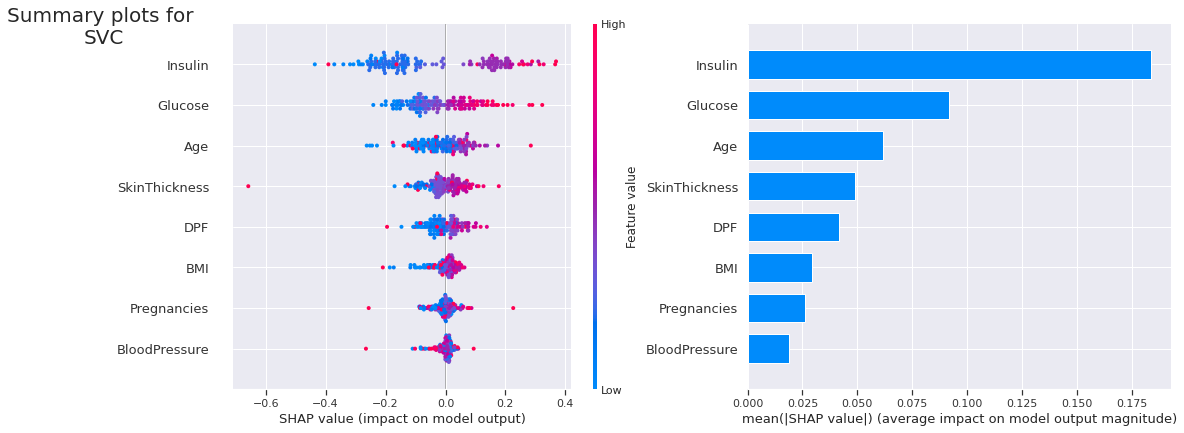

In [290]:
shap_value_plots(shap_values_svc[1], X_test_scaled_os, 'SVC', feature_names=columns)

We can see the variables listed in decreasing order of their impact on the disease outcome.

For SVC, instead of the feature Plasma Glucose concentration, Insulin has the highest impact on the diabetic outcome for a patient, and as seen before, Blood Pressure has the least impact on the model predictions.
- For Insulin and Glucose as the value increases, the person is more likely to be diabetic.
- For Age, certain low values have also yielded an increase in probability of being diabetic.
- For skin thickness and DPF, as the value increases, the person is more likely to be diabetic and vice versa but,
- for BMI, Pregnancies and Blood Pressure, there is mixing of red and blues at the around the zero impact value implying that these three feature did not play a very clear and absolute role in increasing or decreasing the diabetic probability.

### 4. Naive Bayes

In [286]:
# insert trained model into explainer object
explainer_NB = shap.KernelExplainer(nb.predict, X_train_os)
    
# calculate shap values
shap_values_NB = explainer_NB.shap_values(X_test)

Using 802 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/154 [00:00<?, ?it/s]

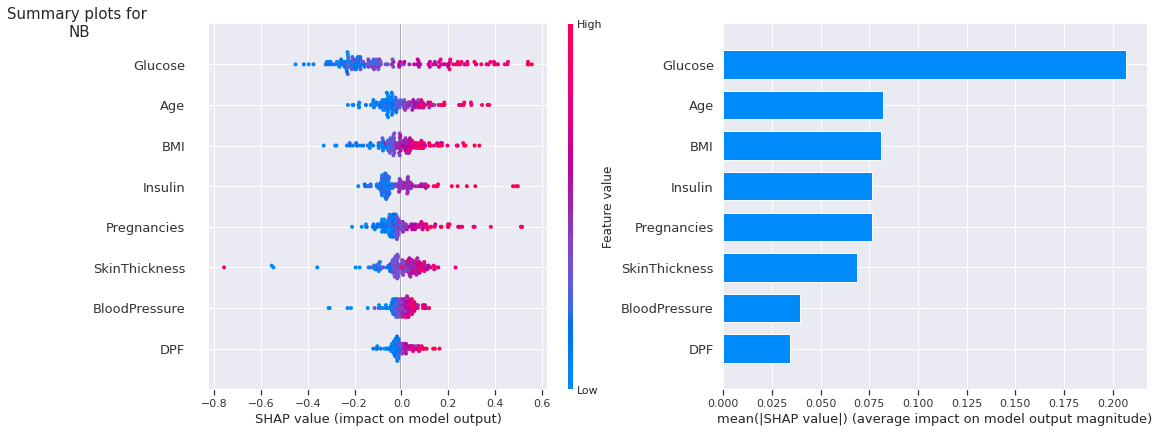

In [288]:
shap_value_plots(shap_values_NB, X_test, 'NB')

We can see the variables listed in decreasing order of their impact on the disease outcome.

So, even for NB, the feature Plasma Glucose concentration has the highest impact on diabetic outcome for a patient. DPf is the feature that had the least impact on the predictions made by the model.
- As the Glucose value increases, the person is more likely to be diabetic.
- For NB, Age and BMI had more impact on the model prediction as compared to serum insulin level.
- In decreasing order of their impact, after glucose,for all the other features including diastolic blood pressure, the probability of being diabetic increases with increase in the variable value.

### 5. Decision Tree

In [270]:
# insert trained model into explainer object
explainer_DT = shap.TreeExplainer(model_dt1, X_train)

# calculate shap values
shap_values_dt = explainer_DT.shap_values(X_test)

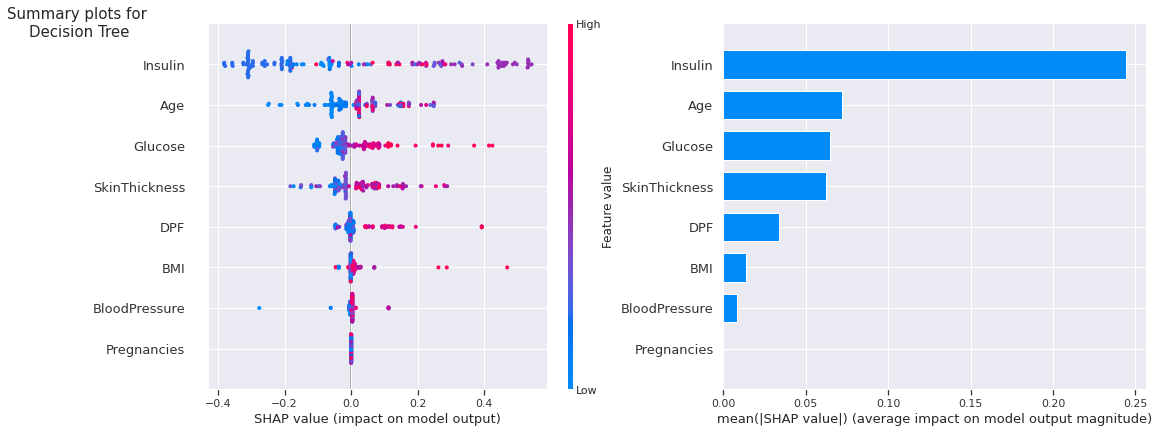

In [274]:
shap_value_plots(shap_values_dt[1], X_test, 'Decision Tree')

We can see the variables listed in decreasing order of their impact on the disease outcome.

For DT we see something different, the feature Insulin levels in the serum 2-hours post glucose administeration has the highest impact on diabetic outcome for a patient. 
- As the insulin level increases, the person is more likely to be diabetic.
- Next most important feature is Age, the increasing value of which is associated with increased probability to be diabetic.
- Next, as the Glucose value increases, the person is more likely to be diabetic.
- For Skin thickness and DPF increasing value is associated with increased probability of being diabetic.
- For BMI, Blood Pressure and Pregnancies most of the points are concentrated around the 0 impact value signifying that these three feature don't really have any impact on predictions made by the Decision Tree model.

### 6. Random Forest Classifier

In [291]:
# insert trained model into explainer object
explainer_RFC = shap.TreeExplainer(model_rfc2, X_train_os)

# calculate shap values
shap_values_RFC = explainer_RFC.shap_values(X_test)

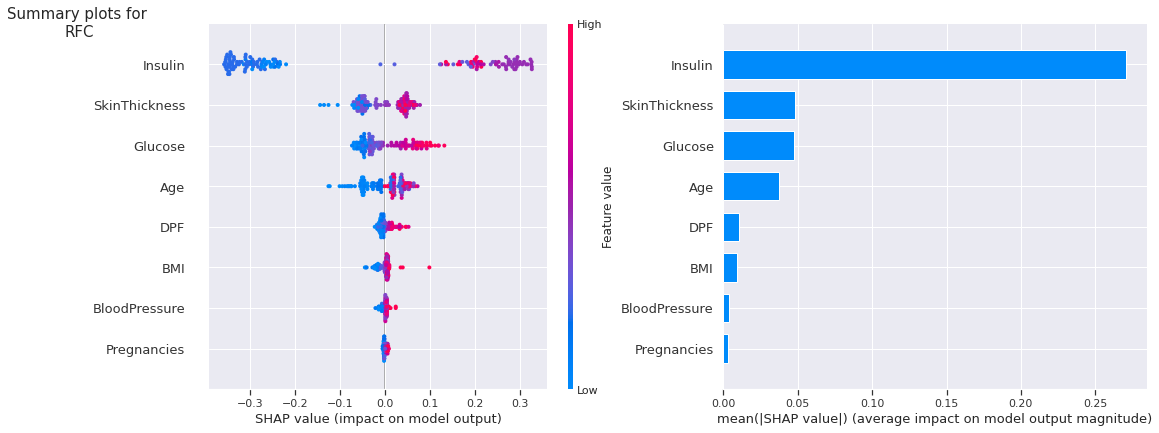

In [293]:
shap_value_plots(shap_values_RFC[1], X_test, 'RFC')

We can see the variables listed in decreasing order of their impact on the disease outcome.

Similar to DT, for RFC the feature with the highest impact on feature predictions has been serum insulin levels, and the least important feature has been pregnancies.
<font color='red'>The most interesting thing to note is that unlike all the other models, we can see quite a distinction in distribution of the red and blue points implying that the features have played a very clear role in either increasing or decreasing the prediction probabilities for the diabetic class 1.</font>

- For RFC , serum insulin levels has had a very high impact relative to other features in increasing the probability of being diabetic.
- Skin thickness and glucose bear almost the same importance in the diabetic predictions, with increasing values leading to increased probability of person being diabetic.
- In decreasing order of their impact, after glucose,for all the other features the probability of being diabetic increases with increase in the variable value.
- With BP and Pregnancies being the features with least impact on predictions made by the model, we can see a crowding of points near the zero impact value, but nonetheless, we see that increase in their value is related to increased probability of being diabetic.

### 7. GBM Classifier 

In [294]:
# insert trained model into explainer object
explainer_GBM = shap.TreeExplainer(gen_model_gbm, X_train_os)

# calculate shap values
shap_values_GBM = explainer_GBM.shap_values(X_test)

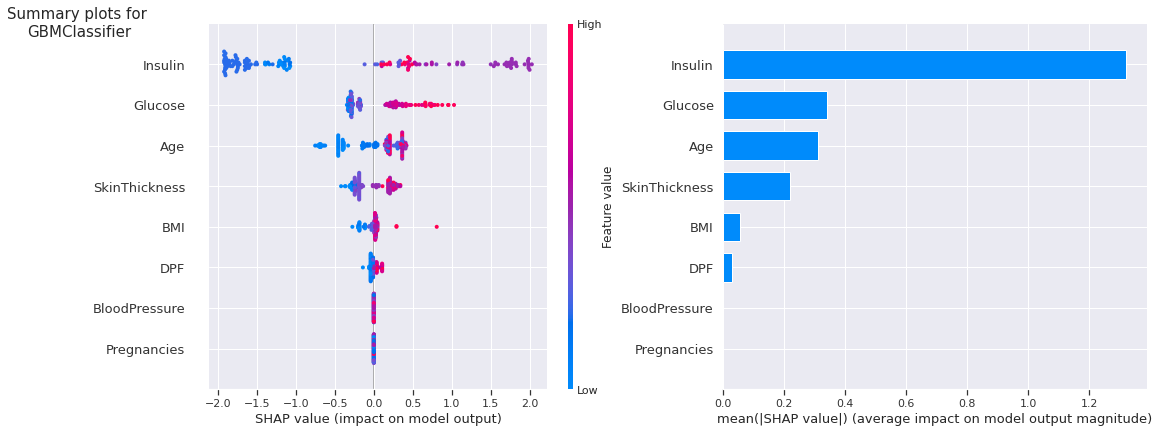

In [295]:
shap_value_plots(shap_values_GBM, X_test, 'GBMClassifier')

We can see the variables listed in decreasing order of their impact on the disease outcome.

For GBM also, the feature Insulin has the highest impact on diabetic outcome for a patient. Blood Pressure and Pregnancies has no impact at all.
- Similar to RFC, serum insulin levels has a very high impact relative to other features in increasing the probability of being diabetic.
- then in the decreasing order of their impact, after glucose,for all the other features the probability of being diabetic increases with increase in the variable value.
- With BP and Pregnancies being the features with No impact on the predictions made by the model.


### 8. LGBMClassifier

In [296]:
# insert trained model into explainer object
explainer_LGBM = shap.TreeExplainer(gen_model_lgb, X_train_os)

# calculate shap values
shap_values_LGBM = explainer_LGBM.shap_values(X_test)

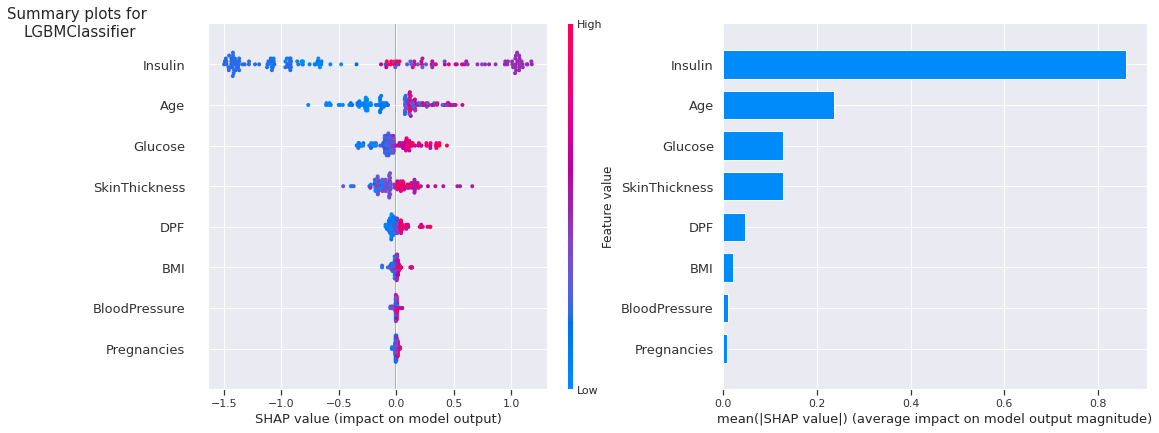

In [297]:
shap_value_plots(shap_values_LGBM, X_test, 'LGBMClassifier')

Similar to all the tree based models till now, for LGBMClassifier, the feature Insulin has the highest impact on diabetic outcome for a patient. Blood Pressure and Pregnancies has a very minimum near zero impact.
- After Insulin in the decreasing order of their impact on the model prediction,for all the other features higher values are associated with a positive impact on the probability of a patient belonging to the diabetic class.

# <font color='palevioletred'>Conclusion</font> 
**- The tree based models work best on the Pima Indian Diabetes dataset since they are able to handle every kind of relationship among the variables as well as between the variables and the target, such as linear, non-linear or no relationship at all. In addition to this, they are also robust to outliers.**

**- Among the Tree based models, the best performance was by GBM Classifier with an AU-ROC of ~94%.**